# Import Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import data from excel
xls = pd.ExcelFile("hk_603ipo_mrk_value.xlsm")

In [3]:
df = pd.read_excel(xls, 'Sheet1')
df['Name']=df['Name'].str.strip("<>")
df.columns = df.columns.astype(str)
df.columns = df.columns.str.replace(" 00:00:00","")
df

,Name,1988-12-30,1989-01-02,1989-01-03,1989-01-04,1989-01-05,1989-01-06,1989-01-09,1989-01-10,1989-01-11,...,2020-06-18,2020-06-19,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-29,2020-06-30,2020-07-01
0,1353.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,610.790,610.790,610.790,610.790,610.790,610.790,610.790,610.790,610.790,610.790
1,1439.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.051,0.051,0.054,0.052,0.051,0.051,0.052,0.053,0.052,0.052
2,1247.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035,0.037,0.035,0.033,0.033,0.033,0.033,0.033,0.032,0.032
3,3332.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.172,0.180,0.180,0.157,0.145,0.145,0.145,0.130,0.130,0.130
4,2080.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.415,0.420,0.405,0.410,0.410,0.410,0.425,0.410,0.410,0.410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,6049.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.550,82.650,79.750,79.100,76.800,76.800,77.750,78.150,78.000,78.000
599,9928.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.240,10.420,10.740,10.480,10.240,10.240,10.520,10.520,10.520,10.520
600,9909.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.060,17.560,17.440,17.880,17.640,17.640,17.720,17.620,17.900,17.900
601,9911.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.100,2.120,1.970,2.030,1.940,1.940,1.970,1.950,1.940,1.940


In [4]:
# Import TR and Return1Year data
tr = pd.read_csv('data_TR.csv',usecols=['Instrument','IPO Date','TRBC Economic Sector Name'])
tr["IPO Date"] = pd.to_datetime(tr["IPO Date"]).dt.strftime('%Y-%m-%d')

stockReturn = pd.read_excel('Short_performance2.xlsx')[['Company','return_1year']]
stockReturn["Company"] = stockReturn["Company"].astype(str).str.cat(['.HK']*603)

tr = tr.merge(stockReturn, left_on='Instrument', right_on='Company')
tr

,Instrument,IPO Date,TRBC Economic Sector Name,Company,return_1year
0,1353.HK,2014-09-01,Consumer Cyclicals,1353.HK,0.000000
1,1439.HK,2014-01-13,Basic Materials,1439.HK,0.000000
2,1247.HK,2014-01-15,Consumer Cyclicals,1247.HK,0.040404
3,3332.HK,2014-01-15,Consumer Cyclicals,3332.HK,0.021053
4,2080.HK,2014-01-23,Real Estate,2080.HK,-0.010753
...,...,...,...,...,...
577,6049.HK,2019-12-19,Real Estate,6049.HK,0.037037
578,9928.HK,2019-12-19,Real Estate,9928.HK,0.018182
579,9909.HK,2019-12-30,Consumer Cyclicals,9909.HK,-0.024645
580,9911.HK,2019-12-31,Consumer Cyclicals,9911.HK,0.031746


# Find peer groups and MktCap

In [5]:
ipodate = tr.loc[tr["Instrument"] == "1353.HK", "IPO Date"].values[0]
marketcap = df.loc[df['Name'] == "1353.HK",ipodate].values[0]
print(str(ipodate) + " " + str(marketcap))

2014-09-01 160.79


In [6]:
# get list of stocks
stocknames = tr['Instrument'].values

# create dataframe with MktCap and return_1year
data = pd.DataFrame(columns = ['Stock','Industry','IPO','MktCap', "return_1year"])
for stock in stocknames:
    try:
        industry = tr.loc[tr["Instrument"] == stock, "TRBC Economic Sector Name"].values[0]
        return_1year = tr.loc[tr["Instrument"] == stock, "return_1year"].values[0]
        ipodate = tr.loc[tr["Instrument"] == stock, "IPO Date"].values[0]
        marketcap = df.loc[df["Name"] == stock, ipodate].values[0]
        if pd.isna(marketcap): continue
        data = data.append({'Stock': stock, 'Industry': industry, 'IPO': ipodate, 'MktCap': marketcap, 'return_1year': return_1year}, ignore_index=True)
    except KeyError as e:
        #print(str(stock) + " " + str(e))
        continue

data

,Stock,Industry,IPO,MktCap,return_1year
0,1353.HK,Consumer Cyclicals,2014-09-01,160.79,0.000000
1,1439.HK,Basic Materials,2014-01-13,0.81,0.000000
2,1247.HK,Consumer Cyclicals,2014-01-15,2.81,0.040404
3,3332.HK,Consumer Cyclicals,2014-01-15,2.66,0.021053
4,2080.HK,Real Estate,2014-01-23,2.84,-0.010753
...,...,...,...,...,...
439,6049.HK,Real Estate,2019-12-19,45.35,0.037037
440,9928.HK,Real Estate,2019-12-19,4.88,0.018182
441,9909.HK,Consumer Cyclicals,2019-12-30,10.06,-0.024645
442,9911.HK,Consumer Cyclicals,2019-12-31,3.25,0.031746


In [7]:
# Find company with best performance among peers
graph_MktCap = []
graph_Return1Year = []

for industry in data.Industry.unique():
    
    divisions = 10 if industry in ["Consumer Cyclicals", "Industrials"] else 1 if industry in ["Utilities", "Energy"] else 4
    size = int(len(data.loc[data["Industry"] == industry].sort_values(by=['MktCap']))/divisions)
    remainder = len(data.loc[data["Industry"] == industry].sort_values(by=['MktCap']))%divisions
    
    print("Industry: " + str(industry))
    mc, r1y = [], []
    
    for d in range(divisions):
        
        start = d*size
        end = (d+1)*size+1 if d<remainder else (d+1)*size
        peers = data.loc[data["Industry"] == industry].sort_values(by=['MktCap']).iloc[start:end]
        
        #print(peers.sort_values(by=['return_1year'], ascending=False).iloc[0:1])
        best = peers.sort_values(by=['return_1year'], ascending=False).iloc[0:1]
        stock = best["Stock"].values[0]
        MktCap = round(best["MktCap"].values[0], 3)
        Return1Year = round(best['return_1year'].values[0], 5)
        
        print("Division {} - [Stock: {}] [MktCap: {}] [Return1Year: {}]".format(d+1, stock, MktCap, Return1Year))
        mc.append(MktCap)
        r1y.append(Return1Year)
    
    graph_MktCap.append(mc)
    graph_Return1Year.append(r1y)
    print("=====END=====\n")

Industry: Consumer Cyclicals
Division 1 - [Stock: 2230.HK] [MktCap: 0.31] [Return1Year: 0.07143]
Division 2 - [Stock: 1906.HK] [MktCap: 0.58] [Return1Year: 0.02968]
Division 3 - [Stock: 1872.HK] [MktCap: 0.63] [Return1Year: 0.00821]
Division 4 - [Stock: 1418.HK] [MktCap: 1.1] [Return1Year: 0.05882]
Division 5 - [Stock: 1418.HK] [MktCap: 1.1] [Return1Year: 0.05882]
Division 6 - [Stock: 1575.HK] [MktCap: 1.76] [Return1Year: 0.01709]
Division 7 - [Stock: 1247.HK] [MktCap: 2.81] [Return1Year: 0.0404]
Division 8 - [Stock: 9911.HK] [MktCap: 3.25] [Return1Year: 0.03175]
Division 9 - [Stock: 3709.HK] [MktCap: 4.4] [Return1Year: 0.14894]
Division 10 - [Stock: 1691.HK] [MktCap: 5.49] [Return1Year: 0.09615]
=====END=====

Industry: Basic Materials
Division 1 - [Stock: 1629.HK] [MktCap: 0.76] [Return1Year: 0.01961]
Division 2 - [Stock: 1636.HK] [MktCap: 0.98] [Return1Year: 0.04051]
Division 3 - [Stock: 1452.HK] [MktCap: 1.45] [Return1Year: 0.0838]
Division 4 - [Stock: 3626.HK] [MktCap: 2.61] [Retu

In [8]:
# Find average performance of peer groups
graph_avgMktCap = []
graph_avgReturn1Year = []

for industry in data.Industry.unique():
    
    divisions = 10 if industry in ["Consumer Cyclicals", "Industrials"] else 1 if industry in ["Utilities", "Energy"] else 4
    size = int(len(data.loc[data["Industry"] == industry].sort_values(by=['MktCap']))/divisions)
    remainder = len(data.loc[data["Industry"] == industry].sort_values(by=['MktCap']))%divisions
    
    print("Industry: " + str(industry))
    mc, r1y = [], []
    
    for d in range(divisions):
    
        start = d*size
        end = (d+1)*size+1 if d<remainder else (d+1)*size
        peers = data.loc[data["Industry"] == industry].sort_values(by=['MktCap']).iloc[start:end]
        
        avgMktCap = round(peers["MktCap"].mean(), 3)
        avgReturn1Year = round(peers['return_1year'].mean(), 5)
        
        print("Division {} - [avgMktCap: {}] [avgReturn1Year: {}]".format(d+1, avgMktCap, avgReturn1Year))
        mc.append(avgMktCap)
        r1y.append(avgReturn1Year)
        
    graph_avgMktCap.append(mc)
    graph_avgReturn1Year.append(r1y)
    print("=====END=====\n")

Industry: Consumer Cyclicals
Division 1 - [avgMktCap: 0.282] [avgReturn1Year: 0.00659]
Division 2 - [avgMktCap: 0.479] [avgReturn1Year: 0.00421]
Division 3 - [avgMktCap: 0.704] [avgReturn1Year: -0.01724]
Division 4 - [avgMktCap: 0.982] [avgReturn1Year: -0.0064]
Division 5 - [avgMktCap: 1.227] [avgReturn1Year: -0.00512]
Division 6 - [avgMktCap: 1.76] [avgReturn1Year: -0.00518]
Division 7 - [avgMktCap: 2.787] [avgReturn1Year: 0.00657]
Division 8 - [avgMktCap: 3.457] [avgReturn1Year: 0.00036]
Division 9 - [avgMktCap: 4.391] [avgReturn1Year: 0.0331]
Division 10 - [avgMktCap: 6.314] [avgReturn1Year: 0.00827]
=====END=====

Industry: Basic Materials
Division 1 - [avgMktCap: 0.638] [avgReturn1Year: -0.00295]
Division 2 - [avgMktCap: 1.083] [avgReturn1Year: -0.0028]
Division 3 - [avgMktCap: 1.817] [avgReturn1Year: 0.02282]
Division 4 - [avgMktCap: 2.732] [avgReturn1Year: 0.00805]
=====END=====

Industry: Real Estate
Division 1 - [avgMktCap: 1.261] [avgReturn1Year: -0.00442]
Division 2 - [avgMk

# Plot against Return1Year

In [9]:
import matplotlib.pyplot as plt

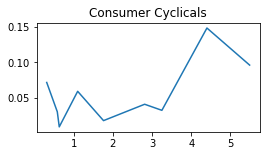

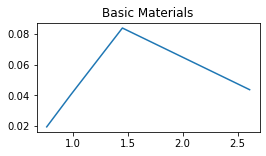

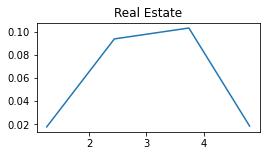

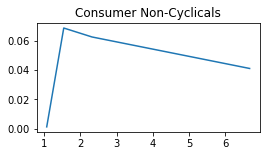

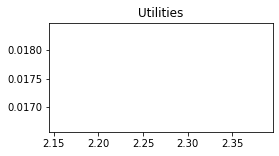

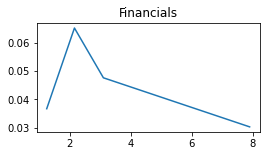

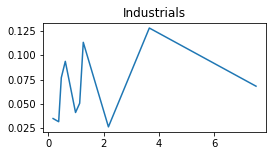

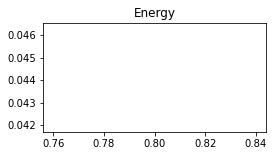

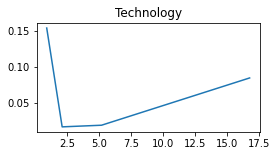

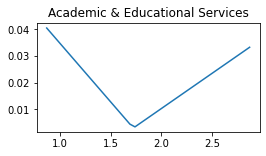

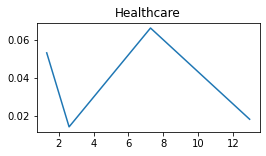

In [10]:
# Plot company with best performance among peers
x1 = graph_MktCap
y1 = graph_Return1Year

industries = data.Industry.unique()
for i in range(len(industries)):
    plt.figure(figsize=(4, 2))
    plt.title(industries[i])
    plt.plot(x1[i],y1[i])

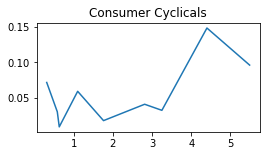

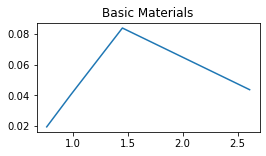

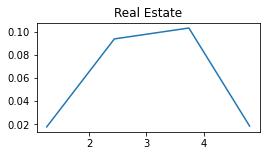

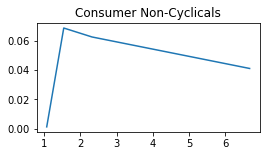

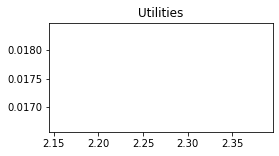

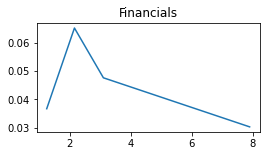

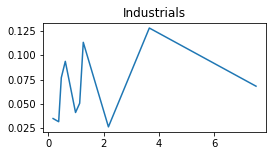

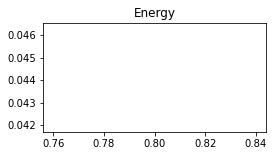

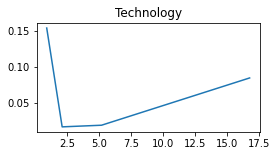

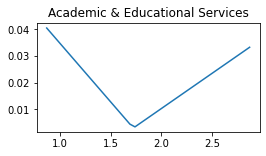

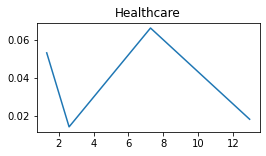

In [11]:
# Plot average performance of peer groups
x2 = graph_avgMktCap
y2 = graph_avgReturn1Year

industries = data.Industry.unique()
for i in range(len(industries)):
    plt.figure(figsize=(4, 2))
    plt.title(industries[i])
    plt.plot(x1[i],y1[i])